# Лабораторная работа №2. Дискриминантный анализ.


### 1. Подготовка библиотек
Импортируем необходимые библиотеки:

In [1]:
import numpy as np # поддерживает матрицы, массивы, мат.функции для них
import pandas as pd # библиотека для анализа данных
from scipy.stats import f
from scipy.spatial.distance import mahalanobis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### 2. Преддискриминантный этап анализа
Целью дискриминантного анализа является разделение рассматриваемой совокупности объектов или явлений на заданные обучающими выборками классы. Исходные данные для анализа представлены в виде матрицы.

Есть два способа создания тренировочной выборки - с помощью списка TRAIN_SAMPLES или заполнение вручную стобца в Excel-файле.

In [2]:
_ = \
"""
    Что поменять:
        0) названия файлов, для считывания и для записи(этот в самом конце)
        1) FEATURES
        2) задать TRAIN_SAMPLES, если не задается, то удалить параметр из вызова функции gen_train_data
        3) задать F to enter в sda
"""

In [3]:
# В переменную FEATURES записываем названия показателей
FEATURES = ["X1", "X2", "X3", "X4", "X5"] 

# создаем словарь - для каждого класса перечисляем номера объектов тренировочной выборки в зависимости от варианта
TRAIN_SAMPLES = {
    1 : [1, 3, 4, 5, 6, 8, 24, 29, 43],
    2 : [14, 15, 16, 21, 23, 27, 28, 41],
}

In [4]:
data = pd.read_excel("data_for_lab2_part1.xlsx") # считываем данные из файла (файл, который содержит ВСЕ строки и ВСЕ признаки)
data.head() #по умолчанию метод head выведет первые 5 строк

,X1,X2,X3,X4,X5
1,9.26,0.78,1.37,0.23,1.45
2,9.38,0.75,1.49,0.39,1.30
3,12.11,0.68,1.44,0.43,1.37
4,10.81,0.70,1.42,0.18,1.65
5,9.35,0.62,1.35,0.15,1.91


Создаем новую переменную, в которую будем записывать все данные, которые необходимо включить в итоговый Excel-файл.

In [5]:
data_to_excel = data[FEATURES]

Далее, вводим функцию gen_train_data по созданию тренировочной выборки.
<br>Аргументы функции: 
- data - данные для анализа
- features - названия признаков 
- train_samples - опциональный параметр: если он передан, то разбиение классов обучающей выборкой задается при помощи train_samples (1 часть ЛР), в противном случае разбиение должно присутствовать в одном из столбцов data (2 часть ЛР)

In [6]:
def gen_train_data(data, features, train_samples=None):
    if train_samples: # если опциональный параметр задан
        train_data = pd.DataFrame() # создаем тренировочную выборку, пока пустую
        for cls, samples in train_samples.items(): # в cls записываем номера классов, в samples список объектов этого класса
            train_samps = data[features].loc[samples] # выбираем объекты обучающей выборки
            train_samps["Class"] = cls # добавляем к ним колонку с номером класса
            train_data = pd.concat([train_data, train_samps]) # concat - функция объединения таблиц
    else:
        assert data.shape[1] == len(features) + 1 # если в исходном файле нет доп.колонки с разбиением, выдаст ошибку
        train_data = data.dropna() # берем в тренировочную выборку только те строки, где проставлены классы
        cls_col = train_data.drop(columns=features).columns[0] 
        train_data = train_data.rename({cls_col: "Class"}, axis=1) # переименовываем колонку с обучающей выборкой на  "Class"
    train_data = train_data.astype({"Class": 'int32'}) # присваем колонке "Class" тип int
    return train_data

In [7]:
# если классы заданы в файле - TRAIN_SAMPLES надо удалить
train_data = gen_train_data(data, FEATURES, TRAIN_SAMPLES)
train_data.head() # смотрим результаты работы функции gen_train_data

,X1,X2,X3,X4,X5,Class
1,9.26,0.78,1.37,0.23,1.45,1
3,12.11,0.68,1.44,0.43,1.37,1
4,10.81,0.70,1.42,0.18,1.65,1
5,9.35,0.62,1.35,0.15,1.91,1
6,9.87,0.76,1.39,0.34,1.68,1


Добавим столбец с обучающей выборкой в переменную.

In [8]:
data_to_excel["Train sample"] = train_data.Class

Для расчета Лямбды Уилкса необходимо знать: <br>
1) общая матрица рассеяния: 
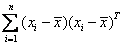

2) внутриклассовые матрицы разброса
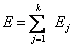

где 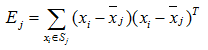

In [9]:
# проведем расчет матрицы рассеяния 

def scatter_matrix(samples):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    d = samples - samples.mean()
    res = np.zeros((d.shape[1], d.shape[1]))
    for _, row in d.iterrows():
        col = row.to_frame()
        res += col @ col.T
    return res

In [10]:
# проведем расчет внутриклассовых матриц разброса

def classes_scatter_matrix(samples, labels):
    A = np.zeros((samples.shape[1], samples.shape[1]))
    for cls in labels.unique():
        A += scatter_matrix(samples[labels == cls])
    return A

Рассчитаем ковариационную матрицу:

In [11]:
# выведем ковариационную матрицу
# она рассчитывается как классовая матрица рассеяния "classes_scatter_matrix", деленная на (кол-во объектов - кол-во классов)

cov = pd.DataFrame(
    classes_scatter_matrix(train_data[FEATURES], train_data.Class) / (train_data.shape[0] - train_data.Class.unique().size), 
    index=FEATURES, 
    columns=FEATURES
)

cov

,X1,X2,X3,X4,X5
X1,0.964345,0.003818,0.022438,0.012281,-0.057013
X2,0.003818,0.002410,0.000349,0.000066,0.008273
X3,0.022438,0.000349,0.005926,-0.003190,-0.010197
X4,0.012281,0.000066,-0.003190,0.038130,-0.008176
X5,-0.057013,0.008273,-0.010197,-0.008176,0.161744


Для проведения дискриминантного анализа используем возможности класса LinearDiscriminantAnalysis.

In [12]:
# "обучаем" модель с помощью метода fit класса LinearDiscriminantAnalysis 
# в метод fit передаем исходные данные
lda = LinearDiscriminantAnalysis().fit(train_data[FEATURES], train_data.Class)

Рассчитаем оценки математических ожиданий в классах.

In [13]:
# выведем средние значения параметров для каждого класса обучающей выборки
means = pd.DataFrame(lda.means_, index=lda.classes_, columns=FEATURES)
means

,X1,X2,X3,X4,X5
1,9.925556,0.722222,1.34000,0.247778,1.877778
2,6.007500,0.743750,1.31875,0.625000,1.135000


### 3.	Дискриминантный анализ

Определим линейные дискриминантные функции Фишера.
Зададим функцию вывода коэффициентов функции Фишера.

In [14]:
def get_df_coef(lda, features):
    if lda.classes_.size == 2: #если 2 класса, то lda вернет разность коэффициентов функций
        return pd.DataFrame(
            np.concatenate([lda.intercept_, lda.coef_.ravel()]),
            index=["Intercept"] + features,
            columns=["Discriminant F"]
        )
# если 3 и более классов, то lda вернет несколько функций (аналогично ППП Statistica)
    return pd.DataFrame(
        np.vstack([lda.intercept_, lda.coef_.T]),
        index=["Intercept"] + features,
        columns=lda.classes_
    )

In [15]:
df_coef = get_df_coef(lda, FEATURES) # применим эту функцию для наших параметров
df_coef

,Discriminant F
Intercept,8.900887
X1,-4.925286
X2,42.035307
X3,4.889948
X4,10.173612
X5,-7.655902


Зададим функцию расчета квадратов расстояний Махаланобиса между классами, где:
 - centers - центры классов
 - samples - объекты, для которых считаем расстояния
 - cov - ковариационная матрицы

In [16]:
def calc_mahalanobis_square_dist(centers, samples, cov):
    # создаем матрицу расстояний между классами и объекnами
    res = pd.DataFrame(index=samples.index, columns=centers.index)
    for i in centers.index: # проходим по всем центрам классов
        for j in samples.index: # проходим по всем объектам
            # считаем расстояние между текущим классом и объектом
            res[i][j] = mahalanobis(centers.loc[i], samples.loc[j], np.linalg.inv(cov)) ** 2 
    return res

In [17]:
# выведем квадраты расстояний Махаланобиса между классами
center_distance = calc_mahalanobis_square_dist(means, means, cov)
center_distance

,1,2
1,0,29.6229
2,29.6229,0


Выведем оценки априорных вероятностей:

In [18]:
lda.priors_ 

array([0.52941176, 0.47058824])

Далее, определим функцию вывода номеров классов для переданных X:

In [19]:
def LDA_predict(lda, X):
    return pd.DataFrame(
        lda.predict(X),
        columns=["Class"],
        index=X.index
    )

Поведем повторную классификацию объектов тренировочной выборки:

In [20]:
lda_predict_train = LDA_predict(lda, train_data[FEATURES])
# сравниваем полученные классы с теми, которые были заданы в начале, и смотрим долю совпадения
(lda_predict_train.Class == train_data.Class).value_counts(normalize=True)

True    1.0
Name: Class, dtype: float64

Получим полную картину классификации всех объектов:

In [21]:
lda_predict = LDA_predict(lda, data[FEATURES])
lda_predict.head()

,Class
1,1
2,1
3,1
4,1
5,1


Запишем результаты классификации в переменную.

In [22]:
data_to_excel["Results lda"] = lda_predict

Выведем квадраты расстояний Махаланобиса между классами и объектами:

In [23]:
samp_dist = calc_mahalanobis_square_dist(means, data[FEATURES], cov)
samp_dist.head()

,1,2
1,5.75425,17.4819
2,8.21605,16.922
3,7.6038,49.8337
4,1.85128,39.1637
5,6.30369,41.236


In [24]:
data_to_excel = pd.concat([data_to_excel, samp_dist.add_prefix("lda mahalanobis ")], axis=1)

Зададим функцию для вывода апостериорных вероятностей:

In [25]:
def LDA_predict_proba(lda, X):
    return pd.DataFrame(
        lda.predict_proba(X),
        columns=lda.classes_,
        index=X.index
    )

Применим функцию LDA_predict_proba для наших данных:

In [26]:
lda_post_prob = LDA_predict_proba(lda, data[FEATURES])
lda_post_prob.head()

,1,2
1,0.997482,2.518378e-03
2,0.988691,1.130931e-02
3,1.000000,6.008216e-10
4,1.000000,7.023529e-09
5,1.000000,2.308814e-08


In [27]:
data_to_excel = pd.concat([data_to_excel, lda_post_prob.add_prefix("lda post prob ")], axis=1)

### 4.	Пошаговый дискриминантный анализ

Зададим функцию расчета Лямбды Уилкса:

In [28]:
def wilks_lambda(samples, labels):
    if isinstance(samples, pd.Series):
        samples = samples.to_frame()
    dT = np.linalg.det(scatter_matrix(samples)) # расчет определителя матрицы рассеяния
    dE = np.linalg.det(classes_scatter_matrix(samples, labels)) # расчет определителя матрицы классового рассеяния
    return dE / dT # их частное и есть Лямбда Уилкса

Зададим функцию расчета f value и p value :
- lmbda - Лямбда Уилкса
- n_obs - кол-во объектов
- n_var - кол-во признаков
- n_cls - кол-во классов

In [29]:
def f_value_wilks_lambda(lmbda, n_obs, n_var, n_cls):
    num = (1 - lmbda) * (n_obs - n_cls - n_var)
    den = lmbda * (n_cls - 1)
    f_value = num / den #значение статистики Фишера
    # f.sf считает p value для определенного значения статистики Фишера и заданных степеней свободы
    p_value = f.sf(f_value, n_cls - 1, n_obs - n_cls - n_var) 
    return f_value, p_value

sda - функция для проведения пошагового дискриминантного анализа:
 - samples - набор объектов
 - labels - названия классов
 - F_in=1e-4 - установленное нами значение F_to_Enter
Функция выводит для каждого шага переменные в модели(into) и вне модели(out) и их характеристики.

In [30]:
def sda(samples, labels, F_in=1e-4):
    stat_columns = ["Wilk's lambda", "Partial lambda", "F to enter", "p-value"]
    n_cls = labels.unique().size # количество классов
    n_obs = samples.shape[0] # количество объектов
    
    # словари для вывода переменных в модели и вне модели на каждом шаге
    out = {0: pd.DataFrame(columns=stat_columns, index=samples.columns, dtype=float)} 
    into = {0: pd.DataFrame(columns=stat_columns, dtype=float)}
    
    step = 0
    while True:
        model_lambda = wilks_lambda(samples[into[step].index], labels) #посчитали Лямбду Уилкса для модели на данном шаге
        
        for x in out[step].index: # проходим по переменным вне модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу    
            lmbda = wilks_lambda(samples[into[step].index.tolist() + [x]], labels) 
            partial_lambda = lmbda / model_lambda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size, n_cls)
            out[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value 
            
        for x in into[step].index: # проходим по переменным в модели на данном шаге
        # далее рассчитываем характеристики для данных переменных и записываем их в таблицу  
            lmbda = wilks_lambda(samples[into[step].index.drop(x)], labels)
            partial_lambda = model_lambda / lmbda
            f_lambda, p_value = f_value_wilks_lambda(partial_lambda, n_obs, into[step].index.size - 1, n_cls)
            into[step].loc[x] = lmbda, partial_lambda, f_lambda, p_value
            
        # критерий для остановки цикла 
        # если вне модели нет переменных ИЛИ новая переменная обладает f_to_enter меньше порогового значения, цикл остановлен
        if out[step].index.size == 0 or out[step]["F to enter"].max() < F_in:
            break
        
        # ищем элемент с max f_to_enter
        x_to_enter = out[step]["F to enter"].idxmax()
        # переносим его из элементов "вне модели" в элементы "в модели"
        into[step + 1] = into[step].append(out[step].loc[x_to_enter])
        out[step + 1] = out[step].drop(index=x_to_enter)
        
        step += 1 # переходим к следующему шагу
        
    return into, out 

Вызываем результаты работы заданной выше функции:

In [31]:
into, out = sda(train_data[FEATURES], train_data.Class, 2.2)

Выводим результаты работы для переменных "в модели" на экран:

In [32]:
for i, t in into.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
Empty DataFrame
Columns: [Wilk's lambda, Partial lambda, F to enter, p-value]
Index: []

Step  1
    Wilk's lambda  Partial lambda  F to enter       p-value
X1            1.0        0.181993   67.420568  6.239812e-07

Step  2
    Wilk's lambda  Partial lambda  F to enter   p-value
X1       0.509392        0.273131   37.257409  0.000027
X5       0.181993        0.764483    4.313034  0.056714



Выводим результаты работы для переменных "вне модели" на экран:

In [33]:
for i, t in out.items():
    print("Step ", i)
    print(t, end="\n\n")

Step  0
    Wilk's lambda  Partial lambda  F to enter       p-value
X1       0.181993        0.181993   67.420568  6.239812e-07
X2       0.948490        0.948490    0.814607  3.810268e-01
X3       0.978937        0.978937    0.322739  5.783717e-01
X4       0.486927        0.486927   15.805458  1.218306e-03
X5       0.509392        0.509392   14.446878  1.740007e-03

Step  1
    Wilk's lambda  Partial lambda  F to enter   p-value
X2       0.176789        0.971401    0.412172  0.531242
X3       0.173910        0.955582    0.650765  0.433330
X4       0.145961        0.802012    3.456093  0.084165
X5       0.139131        0.764483    4.313034  0.056714

Step  2
    Wilk's lambda  Partial lambda  F to enter   p-value
X2       0.119763        0.860796    2.102304  0.170772
X3       0.138869        0.998120    0.024492  0.878044
X4       0.120795        0.868214    1.973266  0.183543



Выводим названия признаков в модели:

In [34]:
stepwise_features = into[len(into) - 1].index.tolist()
stepwise_features

['X1', 'X5']

Проводим дискриминантный анализ для отобранных признаков.

In [35]:
stepwise_lda = LinearDiscriminantAnalysis().fit(train_data[stepwise_features], train_data.Class)

 Выводим коэффициенты функции Фишера на экран.

In [36]:
stepwise_df_coef = get_df_coef(stepwise_lda, stepwise_features)
stepwise_df_coef

,Discriminant F
Intercept,44.415687
X1,-4.426668
X5,-6.152657


Пполучим полную картину классификации всех объектов.

In [37]:
stepwise_lda_predict = LDA_predict(stepwise_lda, data[stepwise_features])
stepwise_lda_predict.head()

,Class
1,1
2,1
3,1
4,1
5,1


Запишем результаты классификации в переменную.

In [38]:
data_to_excel["Results stepwise lda"] = stepwise_lda_predict

In [39]:
stepwise_cov = classes_scatter_matrix(train_data[stepwise_features], train_data.Class) \
    / (train_data.shape[0] - train_data.Class.unique().size)

stepwise_means = pd.DataFrame(stepwise_lda.means_, index=stepwise_lda.classes_, columns=stepwise_features)

stepwise_samp_dist = calc_mahalanobis_square_dist(stepwise_means, data[stepwise_features], stepwise_cov)
stepwise_samp_dist.head()

,1,2
1,1.83714,12.5948
2,2.65839,12.6327
3,5.85345,40.8587
4,1.00562,27.947
5,0.343533,17.5584


In [40]:
data_to_excel = pd.concat([data_to_excel, stepwise_samp_dist.add_prefix("stepwise lda mahalanobis ")], axis=1)

In [41]:
stepwise_lda_post_prob = LDA_predict_proba(stepwise_lda, data[stepwise_features])
stepwise_lda_post_prob.head()

,1,2
1,0.995916,4.083887e-03
2,0.993970,6.030267e-03
3,1.000000,2.226153e-08
4,0.999999,1.254865e-06
5,0.999838,1.624080e-04


In [42]:
data_to_excel = pd.concat([data_to_excel, stepwise_lda_post_prob.add_prefix("stepwise lda post prob ")], axis=1)
data_to_excel.head()

,X1,X2,X3,X4,X5,Train sample,Results lda,lda mahalanobis 1,lda mahalanobis 2,lda post prob 1,lda post prob 2,Results stepwise lda,stepwise lda mahalanobis 1,stepwise lda mahalanobis 2,stepwise lda post prob 1,stepwise lda post prob 2
1,9.26,0.78,1.37,0.23,1.45,1.0,1,5.75425,17.4819,0.997482,2.518378e-03,1,1.83714,12.5948,0.995916,4.083887e-03
2,9.38,0.75,1.49,0.39,1.30,NaN,1,8.21605,16.922,0.988691,1.130931e-02,1,2.65839,12.6327,0.993970,6.030267e-03
3,12.11,0.68,1.44,0.43,1.37,1.0,1,7.6038,49.8337,1.000000,6.008216e-10,1,5.85345,40.8587,1.000000,2.226153e-08
4,10.81,0.70,1.42,0.18,1.65,1.0,1,1.85128,39.1637,1.000000,7.023529e-09,1,1.00562,27.947,0.999999,1.254865e-06
5,9.35,0.62,1.35,0.15,1.91,1.0,1,6.30369,41.236,1.000000,2.308814e-08,1,0.343533,17.5584,0.999838,1.624080e-04


Записываем результаты проведенной работы в файл.

In [43]:
data_to_excel.to_excel("your path")